# 0. Install and Import Dependencies

In [ ]:
!pip install opencv-python matplotlib imageio gdown tensorflow mediapipe Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 96.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import gdown
import zipfile
import mediapipe as mp
from google.colab import output
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import Levenshtein

In [ ]:
url = 'https://drive.google.com/uc?id=1SSlW9fbuDirHLUlfko28MoFLvxwjprxV'
output = 'data.zip'
gdown.download(url, output, quiet=False)
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('data')

Downloading...
From (original): https://drive.google.com/uc?id=1SSlW9fbuDirHLUlfko28MoFLvxwjprxV
From (redirected): https://drive.google.com/uc?id=1SSlW9fbuDirHLUlfko28MoFLvxwjprxV&confirm=t&uuid=e0a26ff9-737b-4f68-aafd-aba39f730439
To: /content/data.zip
100%|██████████| 414M/414M [00:05<00:00, 73.8MB/s]


# 1. Build Data Loading Functions

In [ ]:
def load_video(path: str) -> np.ndarray:
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, min_detection_confidence=0.5)
    cap = cv2.VideoCapture(path)
    frames = []
    mouth_region_resized = None
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(frame_rgb)
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                landmarks = np.array([(lm.x, lm.y) for lm in face_landmarks.landmark])
                min_x = int(np.min(landmarks[4:30, 0]) * frame.shape[1])
                max_x = int(np.max(landmarks[4:30, 0]) * frame.shape[1])
                min_y = int(np.min(landmarks[28:58, 1]) * frame.shape[0])
                max_y = int(np.max(landmarks[28:58, 1]) * frame.shape[0])
                x_end = frame.shape[0] // 7
                y_start = frame.shape[1] // 6
                target_shape = (140, 46)
                mouth_region = frame[min_y + y_start:max_y, min_x:max_x + x_end]
                mouth_region_resized = cv2.resize(mouth_region, target_shape)
                mouth_region_resized = cv2.cvtColor(mouth_region_resized, cv2.COLOR_RGB2GRAY)
                frames.append(mouth_region_resized)
    cap.release()
    face_mesh.close()
    frames1 = np.array(frames)
    sequence_length = 75
    if len(frames) < sequence_length:
        frames.extend([np.zeros_like(mouth_region_resized)] * (sequence_length - len(frames)))
    elif len(frames) > sequence_length:
        frames = frames[:sequence_length]
    frames_array = np.array(frames)
    mean = np.mean(frames_array, axis=(1, 2), keepdims=True)
    std = np.std(frames_array, axis=(1, 2), keepdims=True)
    normalized_frames = (frames_array - mean) / (std + 1e-6)
    return normalized_frames

/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


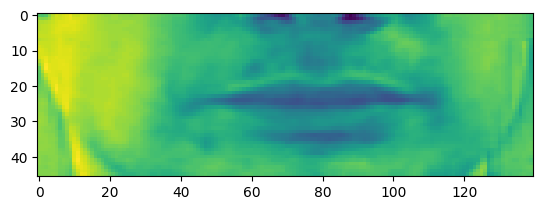

In [ ]:
mouth_frames = load_video('/content/data/t-data/s/bbal6n.mpg')
plt.imshow(mouth_frames[2])
plt.show()

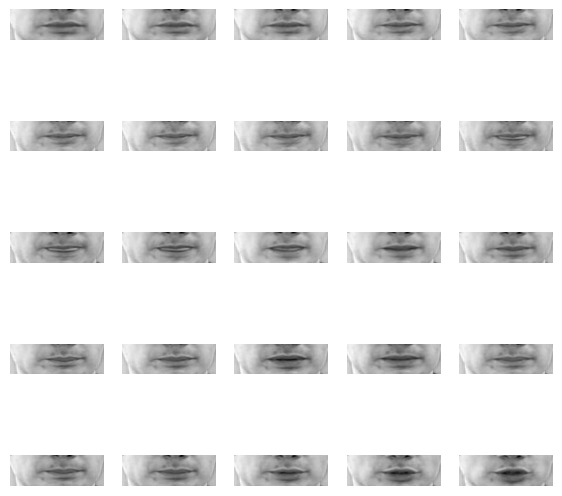

In [ ]:
mouth_frames_squeezed = mouth_frames.squeeze()
fig, axes = plt.subplots(5, 5, figsize=(7, 7))
for i, ax in enumerate(axes.flat):
    if i < mouth_frames_squeezed.shape[0]:
        img = mouth_frames_squeezed[i, :, :] if mouth_frames_squeezed.ndim == 3 else mouth_frames_squeezed[i, :, :, 0]
        ax.imshow(img, cmap='gray')
        ax.axis('off')
plt.show()

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)
print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [ ]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [ ]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','t-data','s',f'{file_name}.mpg')
    alignment_path = os.path.join('data','t-data','align',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    return frames, alignments

In [ ]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [ ]:
data = tf.data.Dataset.list_files('/content/data/t-data/s/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(1, padded_shapes=([75,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
data = data.skip(500)
train = data.take(400)
test = data.skip(400)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 75, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))> <_SkipDataset element_spec=(TensorSpec(shape=(None, 75, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>


In [ ]:
frames1, alignments1 = data.as_numpy_iterator().next()

In [ ]:
sample = data.as_numpy_iterator()

# 3. Design the Deep Neural Network

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

# 4. Setup Training Options and Train


In [ ]:
url = 'https://drive.google.com/uc?id=1--nvQRqIAbAfZaJJHSSm7vM4sAzLJYXW'
output = 'checkpoint-98.weights.h5'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1--nvQRqIAbAfZaJJHSSm7vM4sAzLJYXW
To: /content/checkpoint-100.weights.h5
100%|██████████| 102M/102M [00:01<00:00, 89.3MB/s]


'checkpoint-100.weights.h5'

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset, num_to_char) -> None:
        super().__init__()
        self.dataset = dataset
        self.num_to_char = num_to_char
        self.iterator = self.dataset.as_numpy_iterator()
        self.true_labels = []
        self.predicted_labels = []

    def on_epoch_end(self, epoch, logs=None) -> None:
        try:
            data = self.iterator.next()
        except StopIteration:
            self.iterator = self.dataset.as_numpy_iterator()
            data = self.iterator.next()
            print("End of dataset reached.")
            return

        if data is not None:
            yhat = self.model.predict(data[0])
            decoded = tf.keras.backend.ctc_decode(yhat, [75] * yhat.shape[0], greedy=False)[0][0].numpy()

            original_text = tf.strings.reduce_join(self.num_to_char(data[1][0])).numpy().decode('utf-8')
            predicted_text = tf.strings.reduce_join(self.num_to_char(decoded[0])).numpy().decode('utf-8')
            print('~' * 100)
            print('Original:', original_text)
            print('Prediction:', predicted_text)
            print('~' * 100)


            min_length = min(len(original_text), len(predicted_text))
            self.true_labels.extend(list(original_text[:min_length]))
            self.predicted_labels.extend(list(predicted_text[:min_length]))

            if epoch == self.params['epochs'] - 1:
                self.calculate_metrics()

    def compute_confusion_matrix(self):
        if not self.true_labels or not self.predicted_labels:
            print("No labels collected for confusion matrix.")
            return

        true_labels_flat = self.true_labels
        predicted_labels_flat = self.predicted_labels

        labels = sorted(set(true_labels_flat + predicted_labels_flat))
        label_to_index = {label: idx for idx, label in enumerate(labels)}

        cm = np.zeros((len(labels), len(labels)), dtype=int)

        for true, pred in zip(true_labels_flat, predicted_labels_flat):
            true_idx = label_to_index.get(true, -1)
            pred_idx = label_to_index.get(pred, -1)
            if true_idx != -1 and pred_idx != -1:
                cm[true_idx, pred_idx] += 1

        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    def calculate_metrics(self):
        true_labels_flat = self.true_labels
        predicted_labels_flat = self.predicted_labels

        accuracy = accuracy_score(true_labels_flat, predicted_labels_flat)
        precision = precision_score(true_labels_flat, predicted_labels_flat, average='weighted', zero_division=0)
        recall = recall_score(true_labels_flat, predicted_labels_flat, average='weighted', zero_division=0)
        f1 = f1_score(true_labels_flat, predicted_labels_flat, average='weighted', zero_division=0)

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join(checkpoint_dir,'checkpoint-100.weights.h5'), monitor='loss', save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(train, num_to_char)

In [ ]:
model.load_weights("checkpoint-98.weights.h5")

In [ ]:
val_data = train.take(100) # next 110 and skip 100
val_data = val_data.skip(90)
# total trained epochs: [98 epoch]
# model.fit(train, epochs=4, validation_data=val_data, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/4
400/400 [==============================] - 785s 1s/step - loss: 2.9108 - val_loss: 1.4842 - lr: 1.0000e-04
Epoch 2/4
400/400 [==============================] - 760s 1s/step - loss: 3.0297 - val_loss: 1.3326 - lr: 1.0000e-04
Epoch 3/4
400/400 [==============================] - 767s 1s/step - loss: 2.9461 - val_loss: 1.0464 - lr: 1.0000e-04
Epoch 4/4
400/400 [==============================] - 777s 1s/step - loss: 2.7066 - val_loss: 0.9057 - lr: 1.0000e-04


# 5. Model Evaluation

In [ ]:
url = 'https://drive.google.com/uc?id=1--nvQRqIAbAfZaJJHSSm7vM4sAzLJYXW'
output = 'checkpoint-98.weights.h5'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1--nvQRqIAbAfZaJJHSSm7vM4sAzLJYXW
To: /content/checkpoint-100.weights.h5
100%|██████████| 102M/102M [00:02<00:00, 38.2MB/s] 


'checkpoint-100.weights.h5'

In [ ]:
model.load_weights("checkpoint-98.weights.h5")

/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


1/1 [==============================] - 4s 4s/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green at s one please
Prediction: lay gren at s one please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Predicted Word: 'lay', Similar Words: ['lay', 'green'], Similarity Percentage: 100.00%
Predicted Word: 'gren', Similar Words: ['lay', 'green', 'at'], Similarity Percentage: 80.00%
Predicted Word: 'at', Similar Words: ['green', 'at', 's'], Similarity Percentage: 100.00%
Predicted Word: 's', Similar Words: ['at', 's', 'one'], Similarity Percentage: 100.00%
Predicted Word: 'one', Similar Words: ['s', 'one', 'please'], Similarity Percentage: 100.00%
Predicted Word: 'please', Similar Words: ['one', 'please'], Similarity Percentage: 100.00%
1/1 [==============================] - 0s 138ms/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

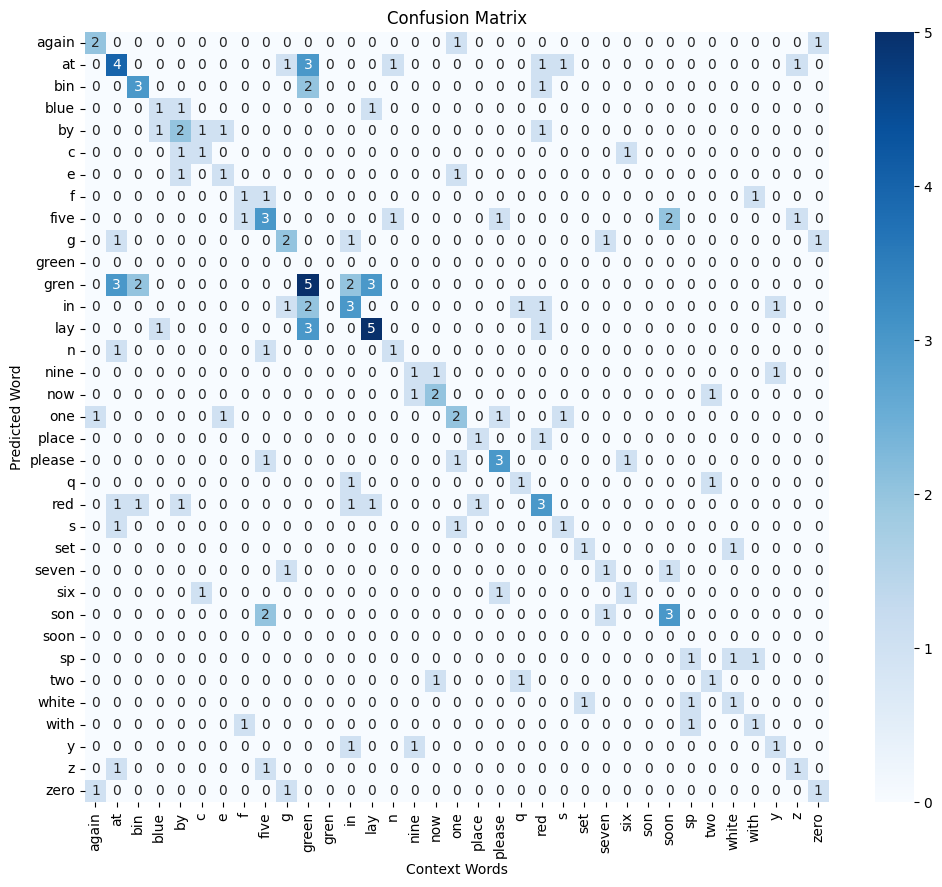

In [ ]:
# To get matrix result per word
def calculate_similarity_matrix(dataset, model, num_to_char):
    sentence_accuracies = []
    sentence_precisions = []
    sentence_recalls = []
    sentence_f1_scores = []
    similar_words = []

    for data in dataset:
        yhat = model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75] * yhat.shape[0], greedy=False)[0][0].numpy()

        original_text = tf.strings.reduce_join(num_to_char(data[1][0])).numpy().decode('utf-8')
        # Check the shape of the decoded tensor
        if decoded.ndim == 1:
            # If it's a single character, convert it to a list
            predicted_text = num_to_char(decoded).numpy().decode('utf-8')
        else:
            # If it's a sequence, use reduce_join as before
            predicted_text = tf.strings.reduce_join(num_to_char(decoded[0])).numpy().decode('utf-8')
        print('~' * 100)
        print('Original:', original_text)
        print('Prediction:', predicted_text)
        print('~' * 100)

        # Tokenize sentences into words
        orig_words = original_text.split()
        pred_words = predicted_text.split()

        # Calculate word-level metrics for this sentence
        correct_words = sum(pred_word in orig_words[max(0, i - 1):min(len(orig_words), i + 2)]
                            for i, pred_word in enumerate(pred_words))
        sentence_accuracy = correct_words / max(len(orig_words), len(pred_words))
        sentence_accuracies.append(sentence_accuracy)

        true_positive = sum(1 for i, pred_word in enumerate(pred_words)
        if pred_word in orig_words[max(0, i - 1):min(len(orig_words), i + 2)])
        false_positive = sum(1 for pred_word in pred_words if pred_word not in orig_words)
        false_negative = sum(1 for orig_word in orig_words if orig_word not in pred_words)

        if true_positive + false_positive > 0:
            precision = true_positive / (true_positive + false_positive)
        else:
            precision = 0.0
        if true_positive + false_negative > 0:
            recall = true_positive / (true_positive + false_negative)
        else:
            recall = 0.0
        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = 0.0
        sentence_precisions.append(precision)
        sentence_recalls.append(recall)
        sentence_f1_scores.append(f1)

        # Find similar words in the predicted sentence
        for i, word in enumerate(pred_words):
            context_indices = range(max(0, i - 1), min(len(orig_words), i + 2))
            context_words = [orig_words[j] for j in context_indices]

            # Calculate similarity percentage using Levenshtein distance
            similarity_percentages = [
                (1 - Levenshtein.distance(word, context_word) / max(len(word), len(context_word))) * 100
                for context_word in context_words
            ]

            best_similarity = max(similarity_percentages)

            similar_words.append((word, context_words, best_similarity))

            print(f"Predicted Word: '{word}', Similar Words: {context_words}, Similarity Percentage: {best_similarity:.2f}%")

    # Calculate overall sentence-level metrics
    overall_sentence_accuracy = np.mean(sentence_accuracies)
    overall_sentence_precision = np.mean(sentence_precisions)
    overall_sentence_recall = np.mean(sentence_recalls)
    overall_sentence_f1_score = np.mean(sentence_f1_scores)

    print(f"Overall Sentence Accuracy: {overall_sentence_accuracy:.4f}")
    print(f"Overall Sentence Precision: {overall_sentence_precision:.4f}")
    print(f"Overall Sentence Recall: {overall_sentence_recall:.4f}")
    print(f"Overall Sentence F1 Score: {overall_sentence_f1_score:.4f}")

    # Compute and display the confusion matrix
    compute_confusion_matrix(similar_words)

def compute_confusion_matrix(similar_words):
    if not similar_words:
        print("No similar words found.")
        return

    labels = sorted(set([word for word, _, _ in similar_words] + [word for _, context, _ in similar_words for word in context]))
    label_to_index = {label: idx for idx, label in enumerate(labels)}

    cm = np.zeros((len(labels), len(labels)), dtype=int)

    for pred_word, context_words, _ in similar_words:
        for context_word in context_words:
            pred_idx = label_to_index.get(pred_word, -1)
            context_idx = label_to_index.get(context_word, -1)
            if pred_idx != -1 and context_idx != -1:
                cm[pred_idx, context_idx] += 1

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Context Words')
    plt.ylabel('Predicted Word')
    plt.title('Confusion Matrix')
    plt.show()
test_val = test.take(10)
# Assuming 'test' is your dataset with the required data points
calculate_similarity_matrix(test_val, model, num_to_char)


1/1 [==============================] - 5s 5s/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red in d eight again
Prediction: lay red in d eight again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1/1 [==============================] - 0s 111ms/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white in k eight please
Prediction: set white in k eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1/1 [==============================] - 0s 114ms/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red at s five now
Prediction: bin red at s five now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1/1 [=================

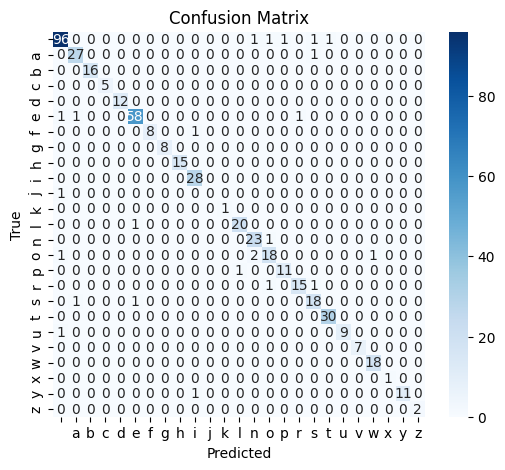

Overall Accuracy: 0.9501
Overall Precision: 0.9488
Overall Recall: 0.9501
Overall F1 Score: 0.9490

Metrics for each character:
Character:  
  Precision: 0.9600
  Recall: 0.9505
  F1 Score: 0.9552
  Support: 101
Character: a
  Precision: 0.9310
  Recall: 0.9643
  F1 Score: 0.9474
  Support: 28
Character: b
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
  Support: 16
Character: c
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
  Support: 5
Character: d
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
  Support: 12
Character: e
  Precision: 0.9667
  Recall: 0.9508
  F1 Score: 0.9587
  Support: 61
Character: f
  Precision: 1.0000
  Recall: 0.8889
  F1 Score: 0.9412
  Support: 9
Character: g
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
  Support: 8
Character: h
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
  Support: 15
Character: i
  Precision: 0.9333
  Recall: 1.0000
  F1 Score: 0.9655
  Support: 28
Character: j
  Precision: 0.0000
  Recall: 0

In [ ]:
# To get matrix result per character
def calculate_chars_similarity_matrix(dataset, model, num_to_char):
    sentence_accuracies = []
    sentence_precisions = []
    sentence_recalls = []
    sentence_f1_scores = []
    similar_words = []
    true_labels= []
    predicted_labels = []

    for data in dataset:
        yhat = model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75] * yhat.shape[0], greedy=False)[0][0].numpy()

        original_text = tf.strings.reduce_join(num_to_char(data[1][0])).numpy().decode('utf-8')
        # Check the shape of the decoded tensor
        if decoded.ndim == 1:
            # If it's a single character, convert it to a list
            predicted_text = num_to_char(decoded).numpy().decode('utf-8')
        else:
            # If it's a sequence, use reduce_join as before
            predicted_text = tf.strings.reduce_join(num_to_char(decoded[0])).numpy().decode('utf-8')
        print('~' * 100)
        print('Original:', original_text)
        print('Prediction:', predicted_text)
        print('~' * 100)

  # Collect true and predicted labels for the confusion matrix
        min_length = min(len(original_text), len(predicted_text))
        true_labels.extend(list(original_text[:min_length]))
        predicted_labels.extend(list(predicted_text[:min_length]))
    compute_confusion_matrix(true_labels, predicted_labels)
    calculate_metrics(true_labels, predicted_labels)

def compute_confusion_matrix(true_labels, predicted_labels):
    if not true_labels or not predicted_labels:
        print("No labels collected for confusion matrix.")
        return

    true_labels_flat = true_labels
    predicted_labels_flat = predicted_labels

    labels = sorted(set(true_labels_flat + predicted_labels_flat))
    label_to_index = {label: idx for idx, label in enumerate(labels)}

    cm = np.zeros((len(labels), len(labels)), dtype=int)

    for true, pred in zip(true_labels_flat, predicted_labels_flat):
        true_idx = label_to_index.get(true, -1)
        pred_idx = label_to_index.get(pred, -1)
        if true_idx != -1 and pred_idx != -1:
            cm[true_idx, pred_idx] += 1

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def calculate_metrics(true_labels, predicted_labels):
    true_labels_flat = true_labels
    predicted_labels_flat = predicted_labels

    # Calculate overall accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(true_labels_flat, predicted_labels_flat)
    precision = precision_score(true_labels_flat, predicted_labels_flat, average='weighted', zero_division=0)
    recall = recall_score(true_labels_flat, predicted_labels_flat, average='weighted', zero_division=0)
    f1 = f1_score(true_labels_flat, predicted_labels_flat, average='weighted', zero_division=0)

    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Overall Precision: {precision:.4f}")
    print(f"Overall Recall: {recall:.4f}")
    print(f"Overall F1 Score: {f1:.4f}")

    # Calculate metrics for each character
    labels = sorted(set(true_labels_flat + predicted_labels_flat))
    print("\nMetrics for each character:")
    for label in labels:
        precision = precision_score(true_labels_flat, predicted_labels_flat, labels=[label], average='micro', zero_division=0)
        recall = recall_score(true_labels_flat, predicted_labels_flat, labels=[label], average='micro', zero_division=0)
        f1 = f1_score(true_labels_flat, predicted_labels_flat, labels=[label], average='micro', zero_division=0)
        support = true_labels_flat.count(label)
        print(f"Character: {label}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        print(f"  Support: {support}")

test_val = test.skip(80)
# Assuming 'test' is your dataset with the required data points
calculate_chars_similarity_matrix(test_val, model, num_to_char)


# 6. Make a Prediction

In [ ]:
test_data = test.as_numpy_iterator()
sample = data.as_numpy_iterator()

In [ ]:
yhat = model.predict(next(sample)[0])

1/1 [==============================] - 0s 161ms/step


In [ ]:
# Extract a batch of data from the iterator
batch = next(sample)
for sentence in batch[1]:
    print('~' * 100, 'REAL TEXT')
    print(tf.strings.reduce_join([num_to_char(word) for word in sentence]))

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT
tf.Tensor(b'lay green at f three please', shape=(), dtype=string)


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place green i o ple'>]

# 7. Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('/content/data/t-data/s/bbaf1n.mpg'))

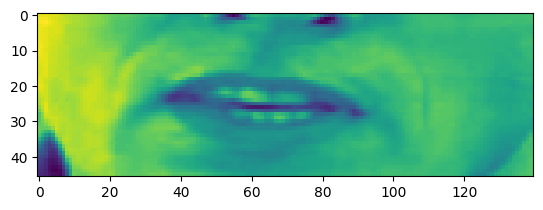

In [ ]:
test1 = sample[0]
plt.imshow(test1[1])

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f one now'>]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 7s 7s/step


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red witn nine oon'>]